In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from numpy.random import default_rng

from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

In [3]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

# Functions

In [4]:
def compute_xi(r_edges, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    
    start = time.time()
    autocorr=1
    res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
    res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
                X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [5]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [6]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [7]:
def generate_shuffled_random(factor, data, rng, redshift_name='redshift_qsoc'):
    N = len(data)
    N_rand = factor*N

    i_vals = np.arange(N)

    i_radec_rand = rng.choice(i_vals, size=N_rand, replace=True)
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    return rand

In [8]:
def generate_shuffled_random_byproperty(factor, data, rng, 
                             property_name, property_by_width, 
                             redshift_name):
    
    i_redshift_rand = []
    i_radec_rand = []
    for i in range(len(data)):
        # get all the objects within given range of given property
        val = data[i][property_name]
        idx_near = np.where((data[property_name] > val-property_by_width) & 
                            (data[property_name] < val+property_by_width))[0]
        
        # choose N=factor objects from that list; assign the random catalogs redshifts of those objects 
        i_redshift_rand_one = rng.choice(idx_near, size=factor, replace=True)
        i_redshift_rand.extend(i_redshift_rand_one)
        # and random ra decs from that set, but separately
        i_radec_rand_one = rng.choice(idx_near, size=factor, replace=True)
        i_radec_rand.extend(i_radec_rand_one)
        
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    
    return rand

In [58]:
import sklearn
sklearn.__version__

'0.23.1'

In [204]:
#from sklearn.neighbors import KDTree
from scipy.spatial import KDTree
def generate_shuffled_random_byproperty_kdtree(factor, data, rng, 
                             property_name, property_width, 
                             redshift_name='redshift_qsoc'):
    
    #features = np.atleast_2d(data[property_name])
    N = len(data[property_name])
    features = np.array(data[property_name]).reshape(N, 1)
    print(features.shape)
    tree = KDTree(features)
    
    print(data[property_name].shape)
    idx_neighbors = tree.query_ball_point(features, property_width)
    print(idx_neighbors.shape)

    idx_neighbors_neat = rng.choice(idx_neighbors, axis=1, replace=True)
    print("neat:", idx_neighbors_neat.shape)
    
    Ns_neighbors = np.array([len(i_n) for i_n in idx_neighbors])
    print(Ns_neighbors.shape)
    print(Ns_neighbors.min(), Ns_neighbors.max())
    
    #print("neighbors", idx_neighbors)
    #i_vals = np.random.randint(low=0, high=Ns_neighbors, size=(factor,N))
    #i_vals = np.random.randint(low=0, high=np.max(Ns_neighbors), size=N)
    i_vals = np.full((N), 100)
    print(i_vals.shape)
    i_vals_arr = np.vstack((np.arange(N), i_vals)).T
    print(i_vals_arr.shape)
    
    #ivals = np.zeros((N, 3), dtype=int)
    #print(len(idx_neighbors[10]))
    #print(idx_neighbors[10][np.max(Ns_neighbors)])
    i_radec_rand = idx_neighbors[i_vals_arr]
    print(i_radec_rand.shape)
    print(kjsdfds)
    
    
    print(np.array(idx_neighbors).shape)
    i_radec_rand = rng.choice(idx_neighbors, size=factor, replace=True, axis=1)
    print(i_radec_rand.shape)

    i_redshift_rand = rng.choice(idx_neighbors, size=factor, replace=True, axis=1)
    print(i_redshift_rand.shape)
    
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    
    return rand 

In [205]:
data_smol = data[::1000]
#data_smol = data[(data['redshift_photoz_est'] < 0.6) & (data['redshift_photoz_est'] > 0.55)]
len(data_smol)

982

In [206]:
property_name = 'redshift_photoz_est'
property_width = 0.1
factor = 3
rand_smol = generate_shuffled_random_byproperty_kdtree(factor, data_smol, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_smol)

(982, 1)
(982,)
(982,)


IndexError: tuple index out of range

In [207]:
def generate_shuffled_random_magbins(factor, data, rng, mag_bins,
                                       redshift_name='redshift_qsoc', mag_name='phot_g_mean_mag'):
    
    ra_rand, dec_rand, redshift_rand, dist_rand = [], [], [], []
    x_rand, y_rand, z_rand = [], [], []
    
    
    for i in range(len(mag_bins)-1):
        idx_mbin = np.where((data[mag_name] > mag_bins[i]) & (data[mag_name] < mag_bins[i+1]))[0]
        N_mbin = len(idx_mbin)
        N_mbin_rand = factor*N_mbin
        
        i_radec_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        ra_rand_mbin = data['ra'][i_radec_rand]
        dec_rand_mbin = data['dec'][i_radec_rand]

        i_redshift_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        redshift_rand_mbin = data[redshift_name][i_redshift_rand]
        dist_rand_mbin = data['distance'][i_redshift_rand]

        x_rand_mbin, y_rand_mbin, z_rand_mbin = radec_to_cartesian(dist_rand_mbin, ra_rand_mbin, dec_rand_mbin)

        ra_rand.extend(ra_rand_mbin)
        dec_rand.extend(dec_rand_mbin)
        redshift_rand.extend(redshift_rand_mbin)
        dist_rand.extend(dist_rand_mbin)
        x_rand.extend(x_rand_mbin)
        y_rand.extend(y_rand_mbin)
        z_rand.extend(z_rand_mbin)
        
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
                names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
                meta={'name': 'random_shuffle_magbins'})
    return rand

In [211]:
def generate_shuffled_random_propertybins(factor, data, rng, property_name, property_bins,
                                          redshift_name):
    
    ra_rand, dec_rand, redshift_rand, dist_rand = [], [], [], []
    x_rand, y_rand, z_rand = [], [], []
    
    
    for i in range(len(property_bins)-1):
        idx_mbin = np.where((data[property_name] > property_bins[i]) & (data[property_name] < property_bins[i+1]))[0]
        N_mbin = len(idx_mbin)
        N_mbin_rand = factor*N_mbin
        
        i_radec_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        ra_rand_mbin = data['ra'][i_radec_rand]
        dec_rand_mbin = data['dec'][i_radec_rand]

        i_redshift_rand = rng.choice(idx_mbin, size=N_mbin_rand, replace=True)
        redshift_rand_mbin = data[redshift_name][i_redshift_rand]
        dist_rand_mbin = data['distance'][i_redshift_rand]

        x_rand_mbin, y_rand_mbin, z_rand_mbin = radec_to_cartesian(dist_rand_mbin, ra_rand_mbin, dec_rand_mbin)

        ra_rand.extend(ra_rand_mbin)
        dec_rand.extend(dec_rand_mbin)
        redshift_rand.extend(redshift_rand_mbin)
        dist_rand.extend(dist_rand_mbin)
        x_rand.extend(x_rand_mbin)
        y_rand.extend(y_rand_mbin)
        z_rand.extend(z_rand_mbin)
        
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
                names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
                meta={'name': 'random_shuffle_propertybins'})
    return rand

# Load in data

In [9]:
fn_photoz = '../data/gaia_photoz.fits'
data = Table.read(fn_photoz, format='fits')
print(len(data))

981927


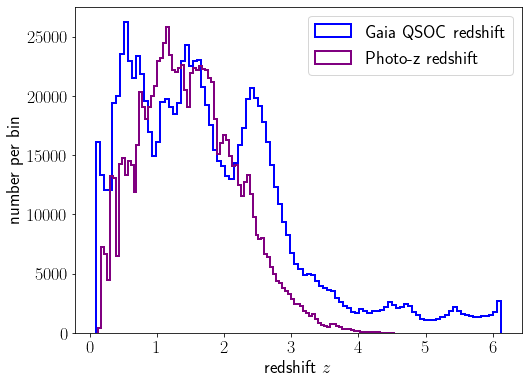

In [10]:
plt.figure(figsize=(8,6))
plt.hist(data['redshift_qsoc'], bins=100, histtype='step', color='blue', lw=2, label='Gaia QSOC redshift')
plt.hist(data['redshift_photoz_est'], bins=100, histtype='step', color='purple', lw=2,label='Photo-z redshift')
plt.xlabel(r'redshift $z$')
plt.ylabel('number per bin')
plt.legend()

### Convert to cartesian

In [11]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(data['redshift_photoz_est'])*cosmo.h).value # convert to Mpc/h
data.add_column(dist, name='distance')

In [12]:
x, y, z = radec_to_cartesian(data['distance'], data['ra'], data['dec'])
data.add_column(x, name='x')
data.add_column(y, name='y')
data.add_column(z, name='z')

In [13]:
norm = np.sqrt(x**2 + y**2 + z**2)

No handles with labels found to put in legend.


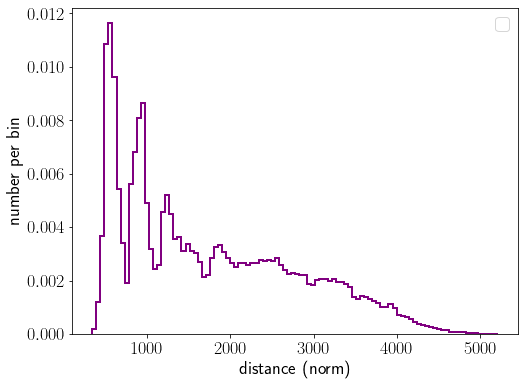

In [43]:
plt.figure(figsize=(8,6))
plt.hist(norm, bins=100, weights=1/(norm**2), histtype='step', color='purple', lw=2)
plt.xlabel(r'distance (norm)')
plt.ylabel('number per bin')
plt.legend()

Text(0.5, 0, 'redshift')

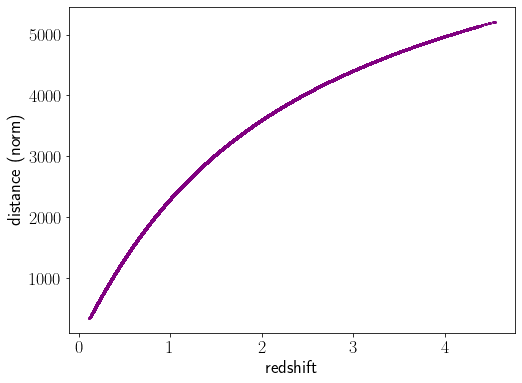

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(data['redshift_photoz_est'], norm, color='purple', s=4)
plt.ylabel(r'distance (norm)')
plt.xlabel('redshift')

# Plot sky area

Text(0, 0.5, 'dec (deg)')

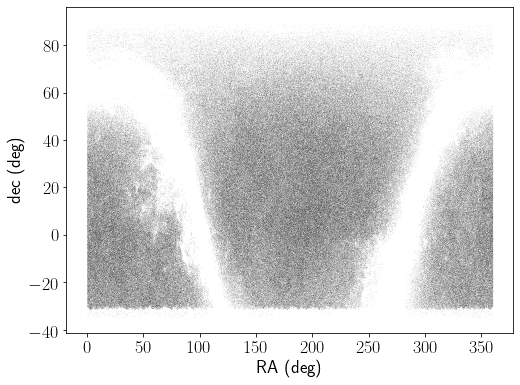

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(data['ra'], data['dec'], s=0.01, alpha=0.1, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

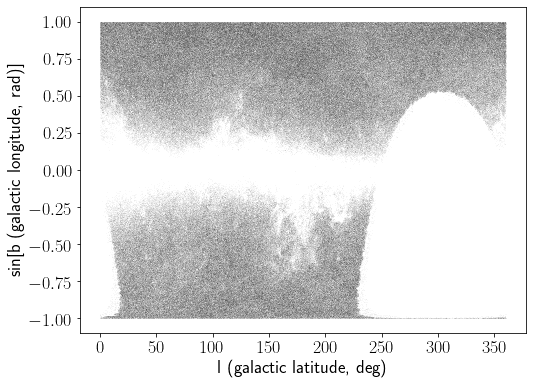

In [17]:
plt.figure(figsize=(8,6))
sinb = np.sin( data["b"] * np.pi/180 )
plt.scatter(data['l'], sinb, s=0.01, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
75905 0.0 0.5
190521 0.5 1.0
254372 1.0 1.5
228894 1.5 2.0
145945 2.0 2.5
60765 2.5 3.0
19227 3.0 3.5
4964 3.5 4.0
600 4.0 4.5


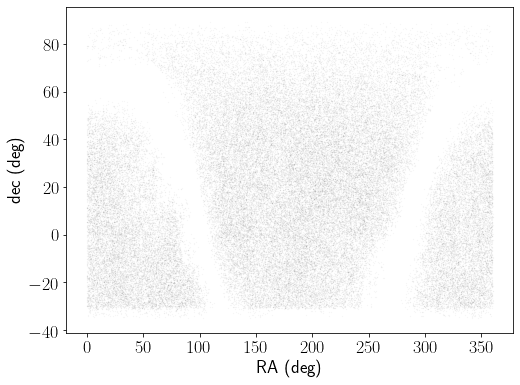

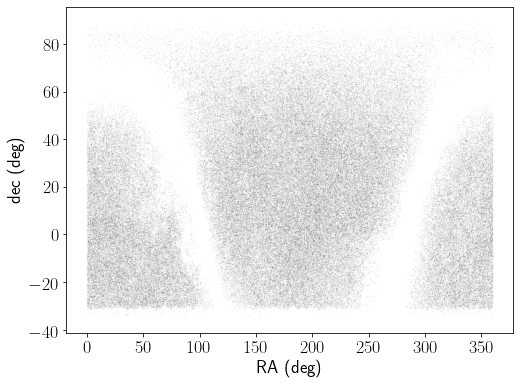

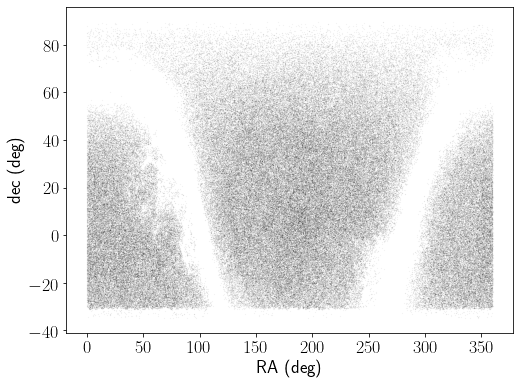

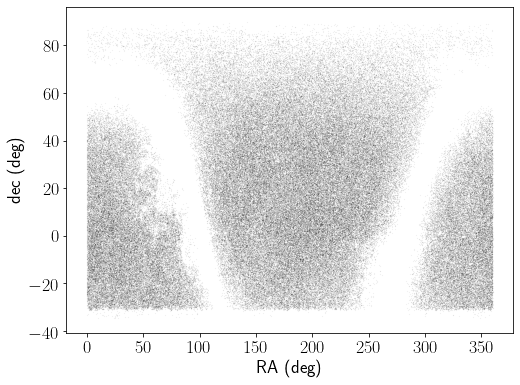

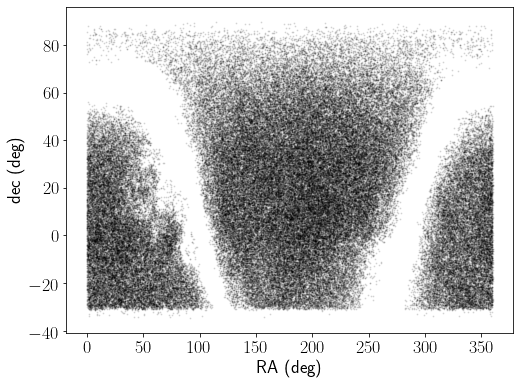

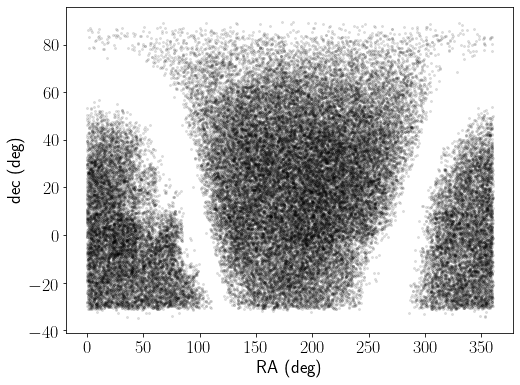

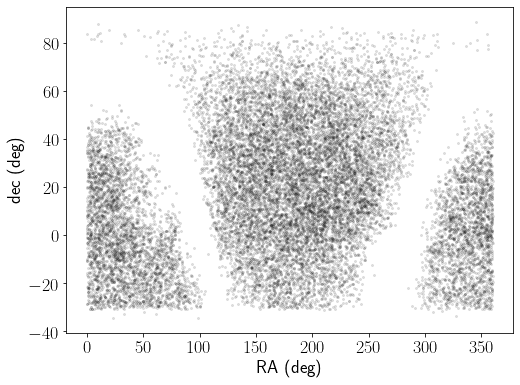

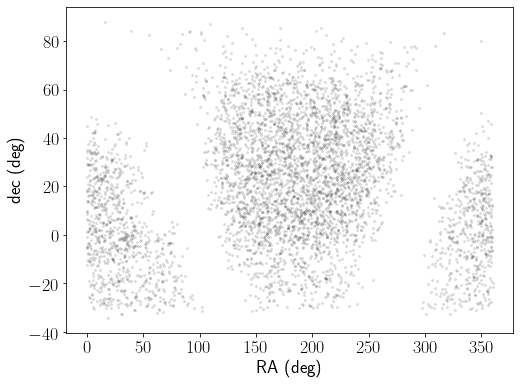

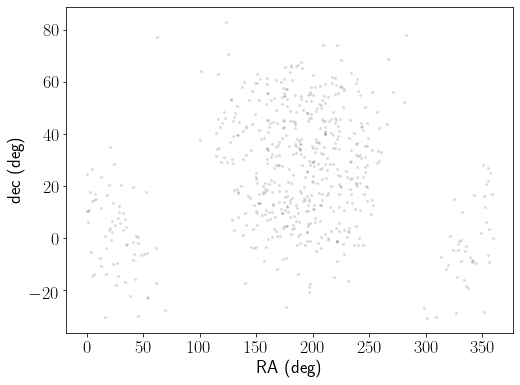

In [18]:
#z_bin_edges = [1, 2]
z_bin_edges = np.linspace(0, 4.5, 10)
ss = [0.02, 0.02, 0.03, 0.05, 1, 4, 4, 4, 4, 4]
print(z_bin_edges)
N_sdss = len(data)
for i in range(len(z_bin_edges)-1):
    idx_zbin = np.where((data['redshift_photoz_est'] > z_bin_edges[i]) & (data['redshift_photoz_est'] < z_bin_edges[i+1]))[0]
    N_zbin = len(idx_zbin)
    print(N_zbin, z_bin_edges[i], z_bin_edges[i+1])
    plt.figure(figsize=(8,6))
    plt.scatter(data['ra'][idx_zbin], data['dec'][idx_zbin], s=ss[i], alpha=0.1, 
                c='k')
    plt.xlabel('RA (deg)')
    plt.ylabel('dec (deg)')

In [19]:
redshift_min, redshift_max = 1, 1.5
dec_max = 60
sinb_lo, sinb_hi = -0.3, 0.3

In [20]:
sinb = np.sin( data["b"] * np.pi/180 )
idx_zslice = np.where((data['redshift_photoz_est'] > redshift_min) &
                      (data['redshift_photoz_est'] < redshift_max) &
                      (data['dec'] < dec_max) &
                      ((sinb > sinb_hi) |
                      (sinb < sinb_lo)))[0]
data_zslice = data[idx_zslice]
len(idx_zslice)

222151

Text(0, 0.5, 'dec (deg)')

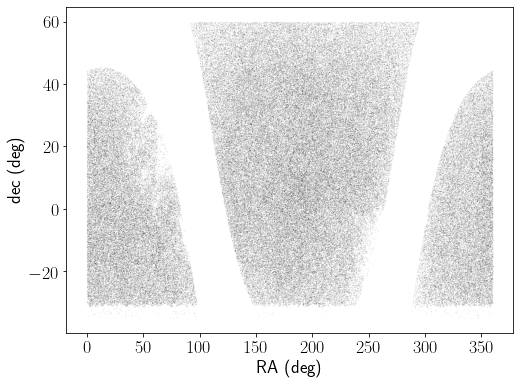

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(data_zslice['ra'], data_zslice['dec'], s=0.03, alpha=0.1, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

Text(0, 0.5, 'sin[b (galactic longitude, rad)]')

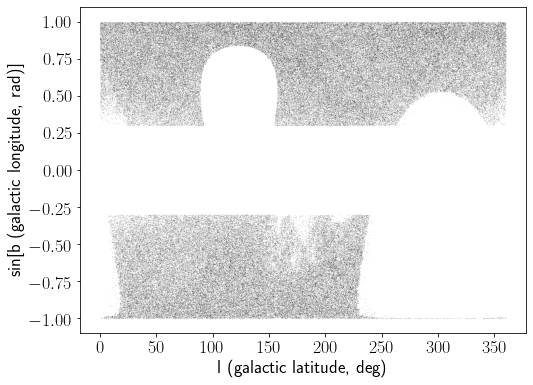

In [22]:
plt.figure(figsize=(8,6))
sinb = np.sin( data_zslice["b"] * np.pi/180 )
plt.scatter(data_zslice['l'], sinb, s=0.03, alpha=0.1, c='k')
plt.xlabel('l (galactic latitude, deg)')
plt.ylabel('sin[b (galactic longitude, rad)]')

# Make random catalog

In [194]:
rng = default_rng(seed=42)

In [195]:
factor = 10

In [196]:
rand = generate_shuffled_random(factor, data, rng, redshift_name='redshift_photoz_est')
len(rand)

9819270

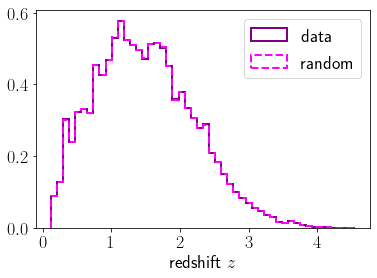

In [197]:
plt.hist(data['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

Text(0, 0.5, 'dec (deg)')

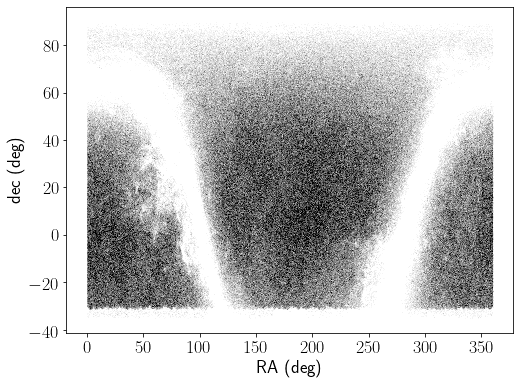

In [198]:
plt.figure(figsize=(8,6))
plt.scatter(rand['ra'], rand['dec'], s=0.03, alpha=0.01, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [199]:
rand_zslice = generate_shuffled_random(factor, data_zslice, rng, redshift_name='redshift_photoz_est')

Text(0, 0.5, 'dec (deg)')

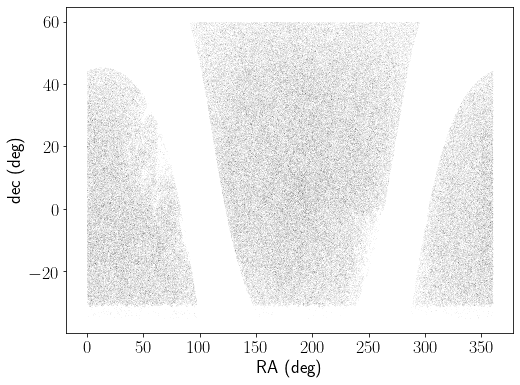

In [200]:
plt.figure(figsize=(8,6))
plt.scatter(rand_zslice['ra'], rand_zslice['dec'], s=0.03, alpha=0.01, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

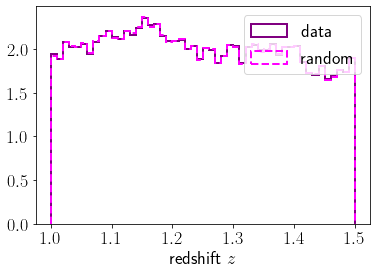

In [201]:
plt.hist(data_zslice['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_zslice['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [202]:
len(data_zslice)

222151

In [203]:
#data_small = data_zslice[:20000]

In [ ]:
property_name = 'redshift_photoz_est'
property_width = 0.0001
factor = 10
rand_zbin_null = generate_shuffled_random_byproperty(factor, data_zslice, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_zbin_null)

In [ ]:
property_name = 'redshift_photoz_est'
property_width = 0.2
factor = 10
rand_zbin = generate_shuffled_random_byproperty(factor, data_zslice, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_zbin)

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(rand_zbin['ra'], rand_zbin['dec'], s=0.01, alpha=0.01, c='k')

plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [ ]:
plt.hist(data_zslice['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_zbin['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [ ]:
property_name = 'redshift_photoz_est'
property_width = 1.0 # will def span whole range
factor = 5
rand_zbin_full = generate_shuffled_random_byproperty(factor, data_zslice, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_zbin_full)

In [ ]:
plt.hist(data_zslice['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_zbin_full['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [ ]:
g_w1 = np.array(data_zslice['phot_g_mean_mag']) - np.array(data_zslice['w1mpro'])
data_zslice.add_column(g_w1, name='g_w1')

In [ ]:
plt.hist(g_w1, bins=30, histtype='step')
plt.xlabel('g - w1 color')

In [ ]:
property_name = 'g_w1'
property_width = 0.3
factor = 10
rand_gw1 = generate_shuffled_random_byproperty(factor, data_zslice, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_gw1)

In [ ]:
plt.hist(data_zslice['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_gw1['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

# Real space correlation function

In [ ]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [ ]:
xi, res_dd, res_dr, res_rr = compute_xi(r_edges, data['x'], data['y'], data['z'], 
                                        rand['x'], rand['y'], rand['z'],
                                        return_full_results=True)

In [ ]:
len(data_zslice)

In [ ]:
len(rand_zslice), len(rand_zbin)

In [ ]:
xi_zslice, res_dd_zslice, res_dr_zslice, res_rr_zslice = compute_xi(r_edges, 
                                        data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                                        rand_zslice['x'], rand_zslice['y'], rand_zslice['z'],
                                        return_full_results=True)

In [ ]:
xi_zbin, res_dd_zbin, res_dr_zbin, res_rr_zbin = compute_xi(r_edges, 
                                        data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                                        rand_zbin['x'], rand_zbin['y'], rand_zbin['z'],
                                        return_full_results=True)

In [ ]:
xi_zbin_null, res_dd_zbin_null, res_dr_zbin_null, res_rr_zbin_null = compute_xi(r_edges, 
                                        data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                                        rand_zbin_null['x'], rand_zbin_null['y'], rand_zbin_null['z'],
                                        return_full_results=True)

In [ ]:
xi_gw1 = compute_xi(r_edges, data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                             rand_gw1['x'], rand_gw1['y'], rand_gw1['z'])

In [ ]:
xi_zbin_full = compute_xi(r_edges, 
                        data_zslice['x'], data_zslice['y'], data_zslice['z'], 
                        rand_zbin_full['x'], rand_zbin_full['y'], rand_zbin_full['z'])

In [ ]:
def power_law(r, r0, alpha):
    return (r/r0)**(alpha)

# fix sloe to 2
def power_law_fixedslope(r, r0):
    return (r/r0)**2

params_initial_guess = [0.04]
bounds = [0, 10]
params_best_fit, _ = curve_fit(power_law_fixedslope, r_avg, res_dd['npairs'], p0=params_initial_guess, bounds=bounds)
power_law_fit_fixedslope = power_law_fixedslope(r_avg, *params_best_fit)

params_initial_guess = [0.04, 2]
bounds = [[0, 0], [10, 10]]
params_best_fit, _ = curve_fit(power_law, r_avg, res_dd['npairs'], p0=params_initial_guess, bounds=bounds)
power_law_fit = power_law(r_avg, *params_best_fit)

In [ ]:
lw=2
plt.figure(figsize=(8,6))
plt.plot(r_avg, res_dd['npairs'], label='DD', color='blue', lw=lw)
plt.plot(r_avg, res_dr['npairs']/factor, label='DR', color='green', lw=lw)
plt.plot(r_avg, res_rr['npairs']/(factor**2), label='RR', color='orange', lw=lw)

plt.plot(r_avg, power_law_fit, label='power law fit', color='grey', ls='--', lw=lw)
plt.plot(r_avg, power_law_fit_fixedslope, label='power law fit', color='grey', ls='--', lw=lw)
plt.xlabel('r (Mpc/h)')
plt.ylabel('pair counts')

plt.xscale('log')
plt.yscale('log')

plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi, where='mid', color='purple', label='full photo-z sample')
plt.step(r_avg, xi_zslice, where='mid', color='forestgreen', 
         label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$')
plt.step(r_avg, res_dd['npairs']/power_law_fit - 1, where='mid', color='red', label='DD/powerlaw - 1')
plt.step(r_avg, res_dd['npairs']/power_law_fit_fixedslope - 1, where='mid', color='orange', 
         label='DD/powerlaw - 1\n(fixed slope)')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

In [ ]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi, where='mid', color='purple', label='full photo-z sample')
plt.step(r_avg, xi_zslice, where='mid', color='forestgreen', 
        label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$')
plt.step(r_avg, xi_zbin_null, where='mid', color='cyan', 
        label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$'+'\n shuffled by zbin=0.0001')
plt.step(r_avg, xi_zbin, where='mid', color='red', 
        label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$'+'\n shuffled by zbin=0.2')
plt.step(r_avg, xi_zbin_full, where='mid', color='magenta', 
        label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$'+'\n shuffled by zbin=1.0')
plt.step(r_avg, xi_gw1, where='mid', color='blue', 
       label=fr'${redshift_min} < z < {redshift_max}$, dec $< {dec_max}$'+'\n shuffled by g-w1=0.1')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

In [ ]:
# not bins, within width

In [ ]:
# test w lognormals

In [ ]:
# b cut to cut out disk
# sfd - dust extinction

# redshift from object in that has a similar value of dust map
# exact same idea of color
# g - w1

## Random catalogs for full sample: Shuffling by property

In [ ]:
len(data)

In [ ]:
property_name = 'redshift_photoz_est'
property_width = 0.5
factor = 5
rand_zshuffle = generate_shuffled_random_byproperty(factor, data, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_zshuffle)

In [ ]:
plt.hist(data['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_zshuffle['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [ ]:
g_w1 = np.array(data['phot_g_mean_mag']) - np.array(data['w1mpro'])
data.add_column(g_w1, name='g_w1')

In [ ]:
plt.hist(g_w1, bins=30, histtype='step')
plt.xlabel('g - w1 color')

In [ ]:
property_name = 'g_w1'
property_width = 0.3
factor = 10
rand_gw1 = generate_shuffled_random_byproperty(factor, data_zslice, rng, property_name, property_width,
                                     redshift_name='redshift_photoz_est')
len(rand_gw1)

In [ ]:
plt.hist(data_zslice['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_gw1['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

## Correlation functions

In [ ]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [ ]:
xi_zshuffle = compute_xi(r_edges, 
                      data['x'], data['y'], data['z'], 
                      rand_zshuffle['x'], rand_zshuffle['y'], rand_zshuffle['z'])

In [ ]:
xi_gw1shuffle = compute_xi(r_edges, 
                      data['x'], data['y'], data['z'], 
                      rand_gw1shuffle['x'], rand_gw1shuffle['y'], rand_gw1shuffle['z'])

In [ ]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi, where='mid', color='purple', label='full photo-z sample')
plt.step(r_avg, xi_zshuffle, where='mid', color='red', 
        label=fr'shuffled by zbin=0.5')
plt.step(r_avg, xi_gw1shuffle, where='mid', color='blue', 
       label=fr'shuffled by g-w1=0.3')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

# High-z

In [34]:
len(data)

981927

In [35]:
redshift_min_highz, redshift_max_highz = 3.25, 4.5
idx_highz = np.where((data['redshift_photoz_est'] > redshift_min_highz) &
                      (data['redshift_photoz_est'] < redshift_max_highz)
                      )[0]
data_highz = data[idx_highz]
len(idx_highz)

11942

Text(0, 0.5, 'dec (deg)')

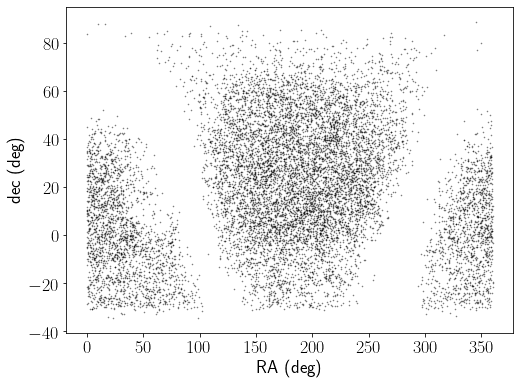

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(data_highz['ra'], data_highz['dec'], s=0.3, alpha=0.5, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

In [37]:
rng = default_rng(seed=42)

In [38]:
factor = 10
rand_highz = generate_shuffled_random(factor, data_highz, rng, redshift_name='redshift_photoz_est')
len(rand_highz)

119420

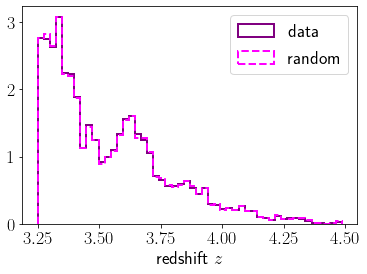

In [39]:
plt.hist(data_highz['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_highz['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [40]:
nthreads = 4
rmin, rmax = 20, 180
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [41]:
xi_highz = compute_xi(r_edges, 
                        data_highz['x'], data_highz['y'], data_highz['z'], 
                        rand_highz['x'], rand_highz['y'], rand_highz['z'])

Time: 0.0891 s
Time: 0.2379 s
Time: 0.1972 s



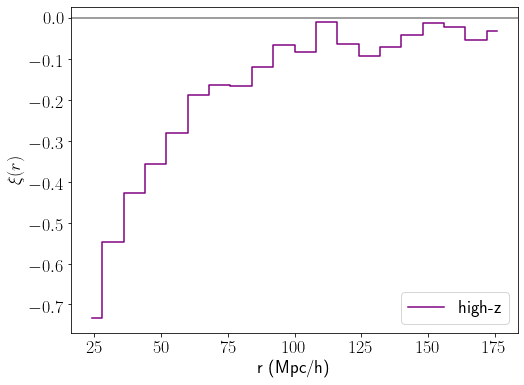

In [42]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_highz, where='mid', color='purple', label='high-z')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

## Attempts at better cf

In [268]:
property_name = 'redshift_photoz_est'
#property_bins = np.percentile(data[property_name], (0,20,40,60,80,100))
property_bins = np.linspace(0, 5, 11)
property_bins = [data[property_name].min(), data[property_name].max()]
redshift_name = 'redshift_photoz_est'
factor = 1
rand_mbins = generate_shuffled_random_propertybins(factor, data, rng, 
                             property_name, property_bins,
                             redshift_name)

In [269]:
# mag_bins = np.percentile(data['phot_g_mean_mag'], (0,20,40,60,80,100))
# print(mag_bins)
# factor = 1
# rand_mbins = generate_shuffled_random_magbins(factor, data, rng, mag_bins,
#                                            redshift_name='redshift_photoz_est', mag_name='phot_g_mean_mag')

In [270]:
len(data)

981927

In [271]:
len(rand_mbins)

981924

Text(0, 0.5, 'dec (deg)')

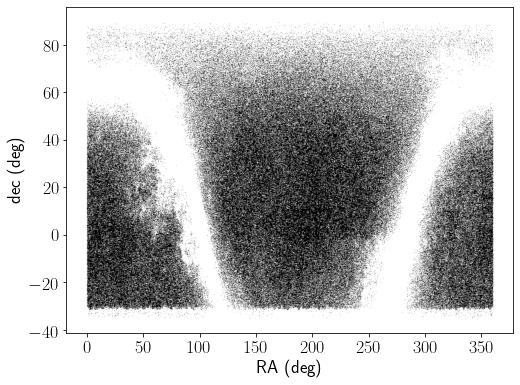

In [272]:
plt.figure(figsize=(8,6))
plt.scatter(rand_mbins['ra'], rand_mbins['dec'], s=0.03, alpha=0.1, c='k')
plt.xlabel('RA (deg)')
plt.ylabel('dec (deg)')

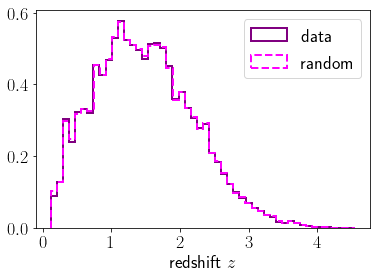

In [273]:
plt.hist(data['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_mbins['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [274]:
xi_mbins = compute_xi(r_edges, 
                      data['x'], data['y'], data['z'], 
                      rand_mbins['x'], rand_mbins['y'], rand_mbins['z'])

Time: 1.7789 s
Time: 3.6115 s
Time: 1.8777 s



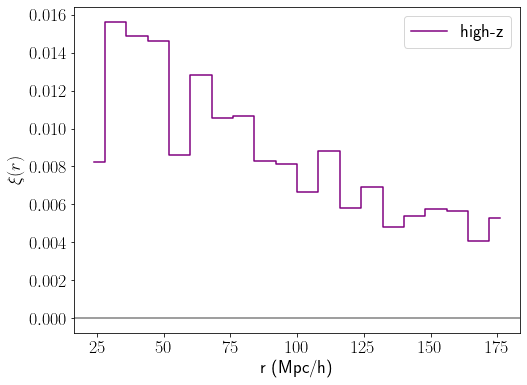

In [275]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_mbins, where='mid', color='purple', label='high-z')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

In [238]:
def uniform_subsample(data, z_min, z_max, redshift_name):
    z_bins = np.linspace(z_min, z_max, 100)
    inds = np.digitize(data[redshift_name], z_bins)
    
    idx_arr = []
    for i in range(1, inds.max()):
        idxs = np.where(inds==i)[0]
        idx_arr.append(idxs)
        
    n_min = np.min([len(idxs) for idxs in idx_arr])
    i_vals_tochoose = []
    for idxs in idx_arr:
        i_vals = np.random.choice(idxs, size=n_min, replace=False)
        i_vals_tochoose.extend(i_vals)
        
    return data[i_vals_tochoose]

In [239]:
data_uniform = uniform_subsample(data, 0.5, 2.5, 'redshift_photoz_est')
len(data_uniform)

359964

[0.         0.26315789 0.52631579 0.78947368 1.05263158 1.31578947
 1.57894737 1.84210526 2.10526316 2.36842105 2.63157895 2.89473684
 3.15789474 3.42105263 3.68421053 3.94736842 4.21052632 4.47368421
 4.73684211 5.        ]


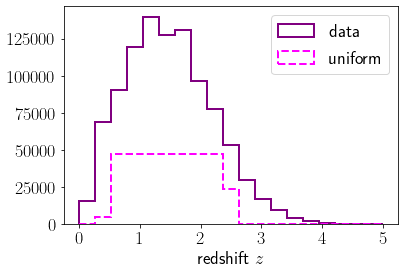

In [240]:
bins = np.linspace(0, 5, 20)
print(bins)
plt.hist(data['redshift_photoz_est'], bins=bins, histtype='step', color='purple', density=False, label='data', lw=2)
plt.hist(data_uniform['redshift_photoz_est'], bins=bins, histtype='step', color='magenta', density=False, label='uniform', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [245]:
factor = 10
rand_uniform = generate_shuffled_random(factor, data_uniform, rng, redshift_name='redshift_photoz_est')
len(rand_uniform)

3599640

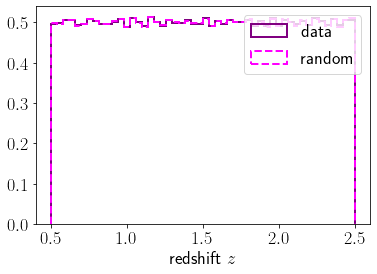

In [246]:
plt.hist(data_uniform['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_uniform['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [247]:
xi_uniform = compute_xi(r_edges, 
                      data_uniform['x'], data_uniform['y'], data_uniform['z'], 
                      rand_uniform['x'], rand_uniform['y'], rand_uniform['z'])

Time: 0.4599 s
Time: 4.2579 s
Time: 15.1973 s



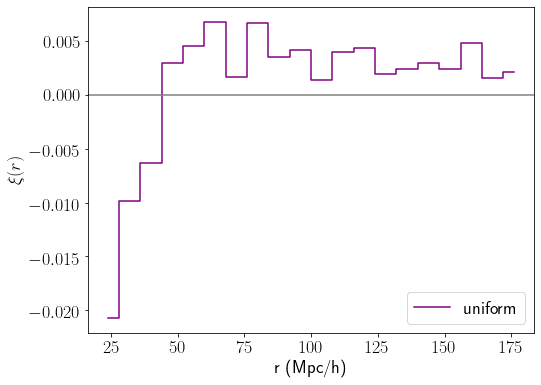

In [248]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_uniform, where='mid', color='purple', label='uniform')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

In [249]:
factor = 5
property_name = 'redshift_photoz_est'

property_bins = np.percentile(data[property_name], (0,20,40,60,80,100))
redshift_name = 'redshift_photoz_est'
factor = 1
rand_uniform_zbins = generate_shuffled_random_propertybins(factor, data_uniform, rng, 
                             property_name, property_bins,
                             redshift_name)

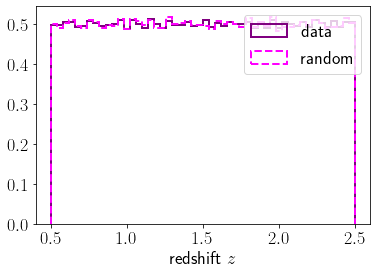

In [250]:
plt.hist(data_uniform['redshift_photoz_est'], bins=50, histtype='step', color='purple', density=True, label='data', lw=2)
plt.hist(rand_uniform_zbins['redshift'], bins=50, histtype='step', color='magenta', density=True, label='random', ls='--', lw=2)
plt.xlabel(r'redshift $z$')
plt.legend()

In [251]:
xi_uniform_zbins = compute_xi(r_edges, 
                      data_uniform['x'], data_uniform['y'], data_uniform['z'], 
                      rand_uniform_zbins['x'], rand_uniform_zbins['y'], rand_uniform_zbins['z'])

Time: 0.4760 s
Time: 0.9822 s
Time: 0.4683 s



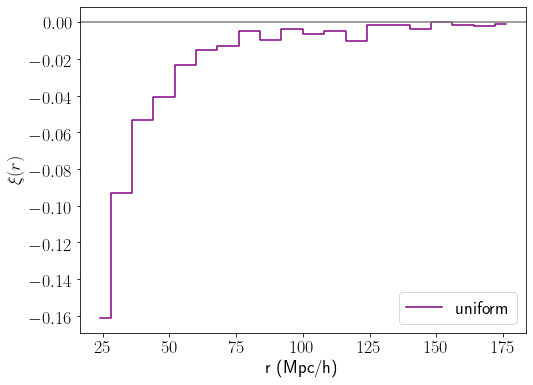

In [252]:
plt.figure(figsize=(8,6))
plt.step(r_avg, xi_uniform_zbins, where='mid', color='purple', label='uniform')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()